Multivariate Regression on Excess US Stock Returns 

*For Illustrative Purposes only

Based on Level II of the CFA Curriculum(Volume 1, Quantitative Methods, page 389)
Credit to the following links for further ideas: https://towardsdatascience.com/simple-and-multiple-linear-regression-with-python-c9ab422ec29c

Dependent Variable(y): Excess Nasdaq 100 One-Month Stock Returns = One-Month Nasdaq 100 Stock Returns minus One-Month T-Bill

Independent Variables(x):

Default Spread(monthly), t-1 = Previous Months Yield on AA Bonds minus yield on AAA Bonds

Term Spread(monthly), t-1 = Previous Months Yield on 10 Yr US Treasury minus Yield on 1 YR US Treasury 

Presidential Party Dummy Variable(monthly), t-1: 1 if President is Democrat, 0 if Republican

In [4]:
import pandas as pd
import numpy as np
from datetime import timedelta, date
import quandl
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [6]:
##Pulling date from respective quandal database. 
#More information can be found at the respective links below
yc_monthly = quandl.get("USTREASURY/YIELD", authtoken="Cx79yxy78FX5iAiqpQBz", collapse="monthly")
#https://www.quandl.com/data/USTREASURY/YIELD-Treasury-Yield-Curve-Rates
nasdaq_data = quandl.get("NASDAQOMX/XNDX", authtoken="Cx79yxy78FX5iAiqpQBz", 
                         transform="rdiff", collapse="monthly")
#https://www.quandl.com/data/NASDAQOMX/XNDX-NASDAQ-100-Total-Return-XNDX
aaa_yields = quandl.get("ML/AAAEY", authtoken="Cx79yxy78FX5iAiqpQBz", collapse="monthly")
#https://www.quandl.com/data/ML/AAAEY-US-AAA-rated-Bond-Index-yield
aa_yields = quandl.get("ML/AAY", authtoken="Cx79yxy78FX5iAiqpQBz", collapse="monthly")
#https://www.quandl.com/data/ML/AAY-US-AA-Bond-Index-Yield

In [7]:
#Remove unncessary columns and drop NaN values
yc_monthly2 = yc_monthly
yc_monthly2 = yc_monthly2.loc[:,['1 MO', '1 YR', '10 YR']].dropna().reset_index()

In [8]:
#Verify NaN drop didn't cause any gaps in dataframe.
yc_monthly2['Date_check'] = yc_monthly2['Date'].diff(1)
print(np.timedelta64(np.nanmax(yc_monthly2['Date_check']),'D'))
print(np.timedelta64(np.nanmin(yc_monthly2['Date_check']),'D'))

31 days
28 days


In [9]:
yc_monthly2 = yc_monthly2.drop(columns='Date_check')

In [10]:
yc_monthly2.tail()

,Date,1 MO,1 YR,10 YR
219,2019-10-31,1.59,1.53,1.69
220,2019-11-30,1.62,1.60,1.78
221,2019-12-31,1.48,1.59,1.92
222,2020-01-31,1.56,1.45,1.51
223,2020-02-29,1.60,1.49,1.59


In [11]:
#Drop last row since data label MTD as month end
yc_monthly2 = yc_monthly2[:-1]

In [12]:
#Calculate Term Spread between 10YR to 1YR
yc_monthly2['Term_Spread'] = yc_monthly2['10 YR'] - yc_monthly2['1 YR']
term_spread = yc_monthly2.loc[:,[ 'Date','Term_Spread']]

In [13]:
term_spread 

,Date,Term_Spread
0,2001-07-31,1.54
1,2001-08-31,1.44
2,2001-09-30,2.11
3,2001-10-31,2.23
4,2001-11-30,2.72
...,...,...
218,2019-09-30,-0.07
219,2019-10-31,0.16
220,2019-11-30,0.18
221,2019-12-31,0.33


In [14]:
nasdaq2 = nasdaq_data 

In [15]:
nasdaq2['Index Value'] = nasdaq2['Index Value']*100
nasdaq2 = nasdaq2.loc[:,['Index Value']].reset_index()
nasdaq2 = nasdaq2.rename(columns={'Trade Date':'Date','Index Value': 'Return'})
#Drop last row since data label MTD as month end
nasdaq2 = nasdaq2[:-1]

In [16]:
#Verify if any data is NaN
nasdaq2.isnull().sum()

Date      0
Return    0
dtype: int64

In [17]:
#Bring in YC to calculate excess returns
excess_return = nasdaq2.merge(yc_monthly2)
#Calculate Excess Return
excess_return['Excess_Return'] = excess_return['Return'] - excess_return['1 MO']
excess_return = excess_return.loc[:,['Date', 'Return']]

In [18]:
aaa_yields2 = aaa_yields.rename(columns={'BAMLC0A1CAAAEY': 'AAA Yield'}).reset_index()
aa_yields2 = aa_yields.rename(columns={'BAMLC0A2CAAEY': 'AA Yield'}).reset_index()
aaa_aa_yields = aaa_yields2.merge(aa_yields2)
aaa_aa_yields = aaa_aa_yields.rename(columns={'DATE': 'Date'})
#Calculate Default Spread
aaa_aa_yields['Default_Spread'] = aaa_aa_yields['AA Yield'] - aaa_aa_yields['AAA Yield']
aaa_aa_yields = aaa_aa_yields[:-1]
default_spread = aaa_aa_yields.loc[:,['Date','Default_Spread']]
default_spread

,Date,Default_Spread
0,1996-12-31,0.10
1,1997-01-31,0.10
2,1997-02-28,0.06
3,1997-03-31,0.08
4,1997-04-30,0.08
...,...,...
273,2019-09-30,-0.11
274,2019-10-31,-0.14
275,2019-11-30,-0.12
276,2019-12-31,-0.15


In [19]:
#Create Presidential Party dummy variable
df_pres = pd.DataFrame(columns=['Date', 'Party'])
date_list = []
start = date(2001,7,31)
end = date(2020,1,31)
def daterange(beg, finish):
    for day in range(int ((finish - beg).days)+1):
          yield start + timedelta(day)
for dt in daterange(start, end):
   date_list.append(dt)
df_pres['Date'] = date_list
gwb_end = date(2009,1,20)
djt_beg = date(2017,1,20)
df_pres['Party'] = df_pres.Date.map( lambda x: 0 if x >= start and x < gwb_end or 
                                    x >= djt_beg and x <= end else 1)
df_pres['Date'] = pd.to_datetime(df_pres['Date'])
df_pres

,Date,Party
0,2001-07-31,0
1,2001-08-01,0
2,2001-08-02,0
3,2001-08-03,0
4,2001-08-04,0
...,...,...
6754,2020-01-27,0
6755,2020-01-28,0
6756,2020-01-29,0
6757,2020-01-30,0


In [20]:
##Verify Dem was applied correctly
df_pres[df_pres['Party']==1]

,Date,Party
2730,2009-01-20,1
2731,2009-01-21,1
2732,2009-01-22,1
2733,2009-01-23,1
2734,2009-01-24,1
...,...,...
5647,2017-01-15,1
5648,2017-01-16,1
5649,2017-01-17,1
5650,2017-01-18,1


In [21]:
#Merge all dateframes ahead of regression
df_main = default_spread.merge(excess_return).merge(term_spread).merge(df_pres)

#Verify there are not all NaN values
df_main.isnull().sum()

Date              0
Default_Spread    0
Return            0
Term_Spread       0
Party             0
dtype: int64

In [22]:
#General overview of dataset
df_main.describe()

,Default_Spread,Return,Term_Spread,Party
count,223.000000,223.000000,223.000000,223.000000
mean,0.046637,0.953806,1.632152,0.430493
std,0.358162,5.823488,1.052276,0.496259
min,-0.630000,-20.501896,-0.480000,0.000000
25%,-0.175000,-2.032015,0.755000,0.000000
50%,-0.020000,1.427072,1.760000,0.000000
75%,0.245000,4.624375,2.540000,1.000000
max,1.280000,18.871068,3.430000,1.000000


In [23]:
#Lag all other variables by shifting Returns by 1 month
df_main2 = df_main.set_index('Date')
df_main2['Return'] = df_main2['Return'].shift(-1)
df_main2 = df_main2.dropna()
df_main2

,Default_Spread,Return,Term_Spread,Party
Date,,,,
2001-07-31,0.19,-12.698733,1.54,0
2001-08-31,0.22,-20.501896,1.44,0
2001-09-30,0.18,16.817533,2.11,0
2001-10-31,0.18,16.953741,2.23,0
2001-11-30,0.21,-1.188093,2.72,0
...,...,...,...,...
2019-08-31,-0.08,0.827435,-0.26,0
2019-09-30,-0.11,4.369851,-0.07,0
2019-10-31,-0.14,4.102627,0.16,0


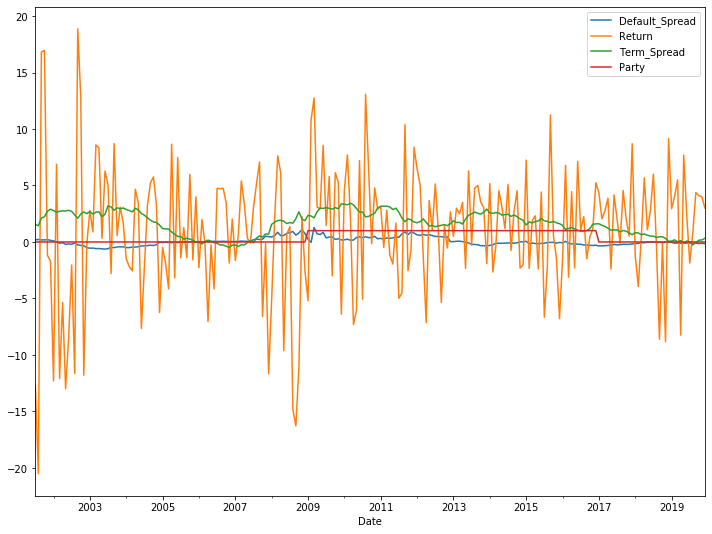

In [24]:
#Plotting entire dateframe
df_main2.plot(figsize=(12,9))
plt.show()

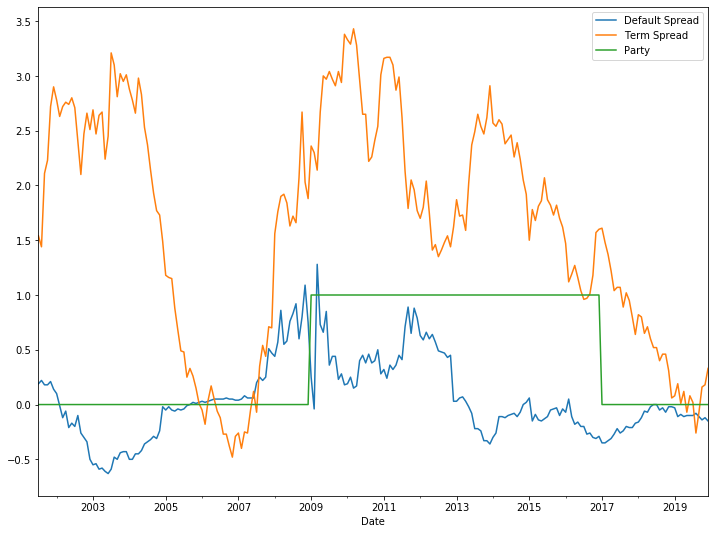

In [25]:
#Plotting Default Spread, Term Spread, and Political Party
#Removes the noise of the Returns from the previous graph
df_main2.Default_Spread.plot(figsize=(12,9))
df_main2.Term_Spread.plot(figsize=(12,9))
df_main2.Party.plot(figsize=(12,9))
plt.legend(labels=['Default Spread','Term Spread', 'Party'])
plt.show()

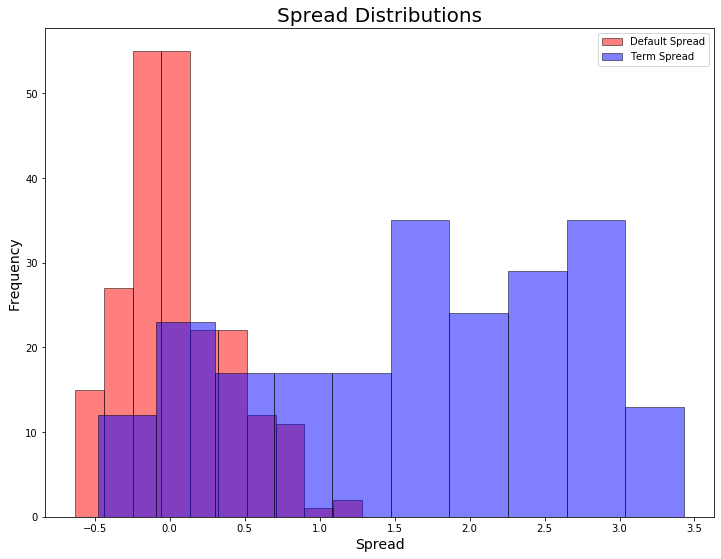

In [26]:
#Distribution of Default and Term Spreads
df_main2.Default_Spread.plot(kind='hist', color='red',edgecolor='black',alpha=0.5,figsize=(12,9))
df_main2.Term_Spread.plot(kind='hist', color='blue',edgecolor='black',alpha=0.5,figsize=(12,9))
plt.legend(labels=['Default Spread','Term Spread'])
plt.title('Spread Distributions', size=20)
plt.xlabel('Spread', size=14)
plt.ylabel('Frequency', size=14);

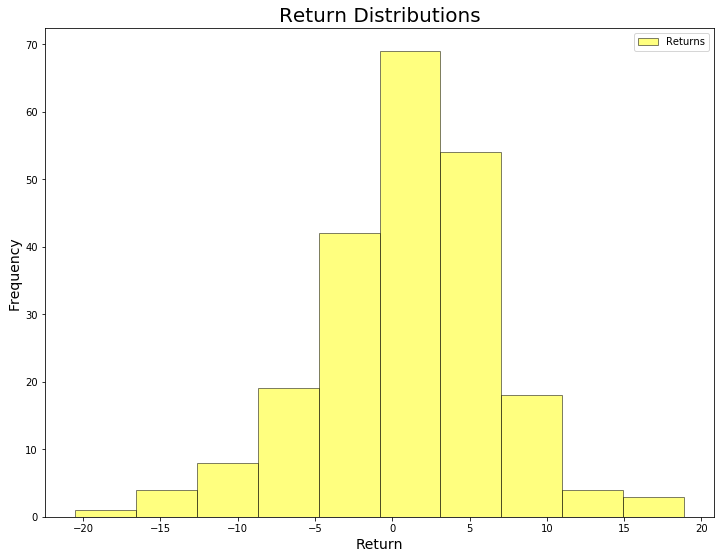

In [27]:
#Distribution of Returns
df_main2.Return.plot(kind='hist', color='yellow',edgecolor='black',alpha=0.5,figsize=(12,9))
plt.legend(labels=['Returns'])
plt.title('Return Distributions', size=20)
plt.xlabel('Return', size=14)
plt.ylabel('Frequency', size=14);

In [28]:
#Calculate Regression coefficents and intercept
reg = LinearRegression()
reg.fit(df_main2[['Default_Spread','Term_Spread', 'Party']], df_main2['Return'])
print(reg.intercept_)
print(reg.coef_)

1.0717130695930317
[-1.82186119 -0.5838219   2.2335907 ]


In [29]:
#Assign independent variables and intercept
intercept = reg.intercept_
default_spread_x = reg.coef_[0]
term_spread_x = reg.coef_[1]
party_x = reg.coef_[2]

In [30]:
#Regression summary
x = df_main2[['Default_Spread','Term_Spread', 'Party']]
y = df_main2['Return']
x = sm.add_constant(x)
anova = sm.OLS(y, x).fit()
anova.summary()

C:\Users\Brett\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     2.318
Date:                Mon, 17 Feb 2020   Prob (F-statistic):             0.0765
Time:                        13:35:47   Log-Likelihood:                -701.47
No. Observations:                 222   AIC:                             1411.
Df Residuals:                     218   BIC:                             1425.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.0717      0.721      1.486      0.139      -0.350       2.494
Default_Spread    -1.8219      1.132     -1.609      0.109      -4.054       0.410
Term_Spread       -0.5838      0.414     -1.409      0.160      -1.400       0.233
Party              2.2336      0.913      2.445      0.015       0.433       4.034
==============================================================================
Omnibus:                        7.271   Durbin-Watson:                   1.901
Prob(Omnibus):                  0.026   Jarque-Bera (JB):               11.894
Skew:                          -0.095   Prob(JB):                      0.00261
Kurtosis:                       4.118   Cond. No.                         6.83
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

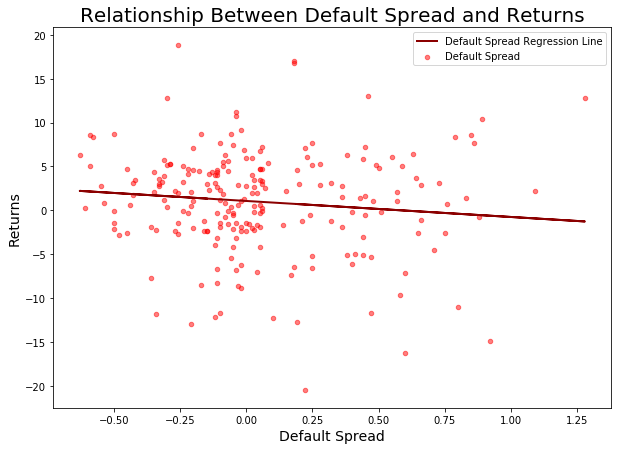

In [31]:
#Regression line and scatter plot for Default Spread
scat1= df_main2.plot(kind='scatter', x='Default_Spread',y='Return', color='red',alpha=0.5, figsize=(10,7))
plt.plot(df_main2.Default_Spread,default_spread_x*df_main2.Default_Spread+intercept, 
         color='darkred', linewidth=2)
plt.legend(labels=['Default Spread Regression Line','Default Spread'])
plt.title('Relationship Between Default Spread and Returns', size=20)
plt.xlabel('Default Spread', size=14)
plt.ylabel('Returns', size=14);

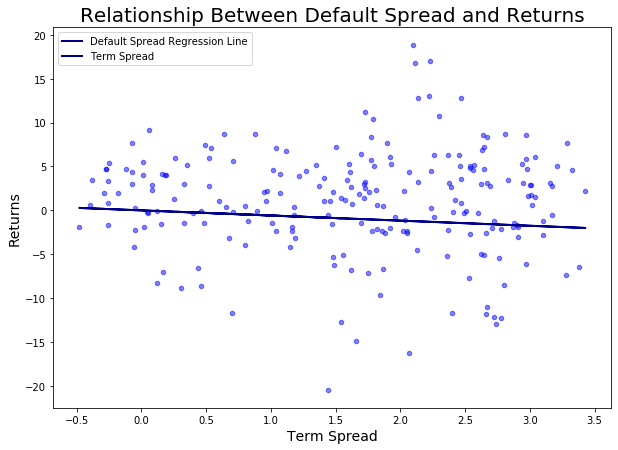

In [32]:
#Regression line and scatter plot for Term Spread
scat2= df_main2.plot(kind='scatter', x='Term_Spread',y='Return', color='blue',alpha=0.5, figsize=(10,7))
plt.plot(df_main2.Term_Spread,term_spread_x*df_main2.Term_Spread,+intercept, 
         color='darkblue', linewidth=2)

plt.legend(labels=['Default Spread Regression Line','Term Spread'])
plt.title('Relationship Between Default Spread and Returns', size=20)
plt.xlabel('Term Spread', size=14)
plt.ylabel('Returns', size=14);

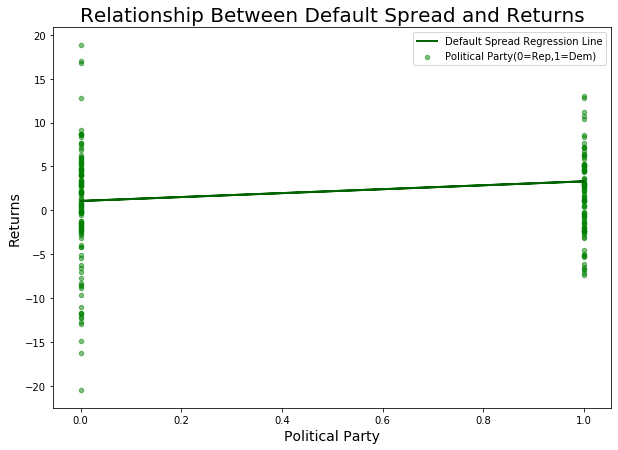

In [33]:
#Regression line and scatter plot for Party
scat3= df_main2.plot(kind='scatter', x='Party',y='Return', color='green',alpha=0.5, figsize=(10,7))
plt.plot(df_main2.Party,party_x*df_main2.Party+intercept, 
         color='darkgreen', linewidth=2)
plt.legend(labels=['Default Spread Regression Line','Political Party(0=Rep,1=Dem)'])
plt.title('Relationship Between Default Spread and Returns', size=20)
plt.xlabel('Political Party', size=14)
plt.ylabel('Returns', size=14);